# Master

## 0. The Dataset.

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
random.seed(1)
###################################################
from time import time
import pickle as pkl
from collections import Counter
from sklearn.model_selection import KFold, GroupKFold, StratifiedKFold, train_test_split
import xgboost
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
import itertools
from sklearn import preprocessing
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings("ignore")

#########################################################


sns.set_style('whitegrid')

font = {'weight' : 'bold',
        'size'   : 14}

%matplotlib inline
# SET PATH
PATH = 'Dataset/NSL-KDD/'

# Header not there, 
col_names = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root',
 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login',
 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate',
 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate', 'label', 'difficulty_level']


> help func.

In [30]:
def get_details(df):
    print('COLUMN NAME:\t Unique Values')
    for i in df.columns :
        print('{} : {}'.format(i, df[i].nunique()))

        value_counts = df[i].value_counts()
        if len(value_counts)>= 5:
            print('\'Top 5 values\'')
            print(value_counts[:5])
        else:
            print(value_counts)
        print('*-'*20)
        

##
np.seterr(divide='ignore', invalid='ignore');
selector = SelectPercentile(f_classif, percentile=10)


def get_univariate_features(X, y, col = col_names):
    x_ids = selector.fit_transform(X,y)
    true = selector.get_support()
    newcolindex_=[i for i, x in enumerate(true) if x]
    newcolname_=list(col[i] for i in newcolindex_)
    return newcolname_,x_ids


## Recursive feature elimination

# Use some other classifier.
clf = DecisionTreeClassifier(random_state=0)
rfe = RFE(estimator=clf, n_features_to_select=13, step=1)

def get_rfe(rfe,X,y, col = col_names):
    rfe.fit(X, y)
    rfe_idx = rfe.transform(X)
    true = rfe.support_
    rfecolindex_ = [i for i, x in enumerate(true) if x]
    rfecolname_ = list(col[i] for i in rfecolindex_)
    return rfe_idx, rfecolname_

# Confusion Matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
# Cross Validation
def mod_stats(dictionary, name,save_fig=False):
    def print_acc(results,model):
        print("Accuracy of {} is {} and std is {}" .format(model ,results.mean()*100, results.std()*100))
    for key ,value in dictionary.items():
        print_acc(value, key)
    results = pd.DataFrame(dictionary).applymap(lambda x: x*100)
    print(results)
    ax = results.plot(**{'linewidth':1.5, 'linestyle':'-.','marker':'o',\
                     'alpha':.6})
    ax.legend(bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                    mode="expand", borderaxespad=0, ncol=3)
    plt.xlabel('n-fold')
    plt.ylabel('%accuracy')
    if save_fig:
        plt.savefig('validation/' + name + '_SKF.jpg',dpi=300,format='jpg')
        
# SKF
def skfold(X, y, model):
    skf = StratifiedKFold(n_splits=10)
    skf.get_n_splits(X, y)
    results = cross_val_score(model, X, y, cv=skf)
    return results


def get_test_train(d_train,d_test,cols):
    X_train = d_train[list(cols)]
    y_train = d_train['label']
    
    X_test = d_test[list(cols)]
    y_test = d_test['label']
    
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train= shuffle(scaler.transform(X_train))
    scaler = preprocessing.StandardScaler().fit(X_test)
    X_test = scaler.transform(X_test)
    return X_train, y_train, X_test, y_test

In [3]:
# attach the column names to the dataset
df = pd.read_csv(PATH+ 'KDDTrain+.txt', header=None, names = col_names)
df_test = pd.read_csv(PATH+ 'KDDTest+.txt', header=None, names = col_names)

# shape, this gives the dimensions of the dataset
print('Dimensions of the Training set:',df.shape)
print('Dimensions of the Test set:',df_test.shape)
df.head()

Dimensions of the Training set: (125973, 43)
Dimensions of the Test set: (22544, 43)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty_level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


Though the dimensions are same but the values which are there are different. <br>
Like in services there are some values which are only present in train dataset but not in train.<br>
Better to take all and make 0 for those not present.
<br>
**Types of Attack which we are trying to detect**
(present in label columns of dataset)
<br>
![Attack Categories](1.jpg "Attack Categories")
![Attack Categories](2.jpg "Attack Categories")

> Taken from two different papers! [link](http://eprints.iisc.ernet.in/26885/1/darpa.pdf) [link](http://airccse.org/journal/nsa/0512nsa08.pdf)

In [5]:
## Uncomment and Run the line below to see detailed info.!
#df.info()

In [4]:
print('TRAINING SET LABEL DISTRIBUTION --')
print(df['label'].value_counts())
print('','*.*.*.'*20,'',sep = '\n\n')
# W
print('TEST SET LABEL DISTRIBUTION --')
print(df_test['label'].value_counts())

#*****************************************************#
#######################################################

# object type can be dummified
# This could be added then be fed to the model.

print('TRAIN DATA\n')
for col_name in df.columns:
    if df[col_name].dtypes == 'object' :
        unique_cat = len(df[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))
        
print('\nTEST DATA\n')

for col_name in df_test.columns:
    if df_test[col_name].dtypes == 'object' :
        unique_cat = len(df_test[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

TRAINING SET LABEL DISTRIBUTION --
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: label, dtype: int64


*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.*.


TEST SET LABEL DISTRIBUTION --
normal             9711
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf           

> **Difference between test and train dataset. Missing Parameters**
(not exactly missing)
There are few columns which we can dumify ( like one hots encoding etc )
We also take the look at the test dataset to see which all serives, protocol etc are there test dataset. 

In [5]:
print('Services')
print(list(set(df['service'].unique()) - set(df_test['service'].unique())))
print(list(set(df_test['service'].unique()) - set(df['service'].unique())))
print('Protocol Type')
print(list(set(df['protocol_type'].unique()) - set(df_test['protocol_type'].unique())))
print(list(set(df_test['protocol_type'].unique()) - set(df['protocol_type'].unique())))
print('Flag')
print(list(set(df['flag'].unique()) - set(df_test['flag'].unique())))
print(list(set(df_test['flag'].unique()) - set(df['flag'].unique())))
print('label')
print(list(set(df['label'].unique()) - set(df_test['label'].unique())))
print(list(set(df_test['label'].unique()) - set(df['label'].unique())))



Services
['red_i', 'http_2784', 'aol', 'harvest', 'http_8001', 'urh_i']
[]
Protocol Type
[]
[]
Flag
[]
[]
label
['spy', 'warezclient']
['processtable', 'xterm', 'worm', 'snmpgetattack', 'xlock', 'ps', 'sqlattack', 'xsnoop', 'apache2', 'httptunnel', 'saint', 'named', 'sendmail', 'udpstorm', 'snmpguess', 'mscan', 'mailbomb']


In [6]:
x = list(set(df['service'].unique()) - set(df_test['service'].unique()))
for i in x:
    df_test['service_'+i] = 0

In [7]:
# ADD DUMMIES
prot_type = pd.get_dummies(df['protocol_type'],prefix='protocol')
service = pd.get_dummies(df['service'],prefix='service')
flag = pd.get_dummies(df['flag'], prefix='flag')

# Test dataset DUMMIES

prot_type_test = pd.get_dummies(df_test['protocol_type'], prefix = 'protocol')
service_test = pd.get_dummies(df_test['service'], prefix = 'service')
flag_test = pd.get_dummies(df_test['flag'], prefix = 'flag')

### **1. Making Train-able**

In [8]:
prot_type_test.head()
new_df = df.drop(labels=['protocol_type', 'service','flag', 'difficulty_level'], axis = 1) # Already created dummies so no need keep it.
new_df = pd.concat([new_df,prot_type, service, flag], axis = 1)
## TEST DATASET
new_df_test = df_test.drop(labels=['protocol_type', 'service','flag', 'difficulty_level'], axis = 1)
new_df_test = pd.concat([new_df_test,prot_type_test, service_test, flag_test], axis = 1)
new_df_test.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2,2,12983,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,20,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,0,15,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


**Sanity check**

In [9]:
# Train dataset
print('Services_http\n{}\nProtocol_tcp{}'.format(new_df['service_http'][:5], new_df_test['protocol_tcp'][:5]))
# Test dataset



Services_http
0    0
1    0
2    0
3    1
4    1
Name: service_http, dtype: uint8
Protocol_tcp0    1
1    1
2    1
3    0
4    1
Name: protocol_tcp, dtype: uint8


In [10]:
df.head() # Original Dataset.

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label,difficulty_level
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [11]:
new_df.head() # This would be used for training #(Notice we have increased feature count .. we seperated feilds and one hots them.)

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0,491,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0,146,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,232,8153,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,0,199,420,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0


> After this we make seperate dataset for each type of attack. 4 Broad categories mentioned above. <br>
These were saved to different files. See Git repo //

In [12]:
# 0=normal, 1=DoS, 2=Probe, 3=R2L and 4=U2R.
label_dict = { 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
 'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2,
 'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
 'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4}

print(len(label_dict))

new_df_test['label'].apply(lambda x: label_dict[x]).value_counts()

40


0    9711
1    7460
3    2885
2    2421
4      67
Name: label, dtype: int64

These were saved under different file names based on their attack type. 
We hoped to determine based learning algorithm for each different attack type. 
In all of those advanced algorithms Decission trees, Random Forest, XGB outperformed other so see the rest of the notebook.<br>
**_checkpoint_1**

## 2.Feature Selection


In [22]:


# Update dataframes

df = pd.read_csv(PATH+'combined_df.csv')
df_test = pd.read_csv(PATH+'combined_test_df.csv')
nor_df = pd.read_csv(PATH+'normal_df.csv')
##########################################################

# 0=normal, 1=DoS, 2=Probe, 3=R2L and 4=U2R.

normal_df = df[df['label'] == 0]

dos_df = df[df['label'] == 1]
dos_df = pd.concat([dos_df,normal_df])
dos_df = shuffle(dos_df)

probe_df = df[df['label'] == 2]
probe_df = pd.concat([probe_df,normal_df])
probe_df = shuffle(probe_df)

r2l_df = df[df['label'] == 3]
r2l_df = pd.concat([r2l_df,normal_df])
r2l_df = shuffle(r2l_df)

u2r_df = df[df['label'] == 4]
u2r_df = pd.concat([u2r_df,normal_df])
u2r_df = shuffle(u2r_df)

# TEST DATASET

Normal_df_test = df_test[df_test['label'] == 0]

Dos_df_test = df_test[df_test['label'] == 1]
Dos_df_test = pd.concat([Normal_df_test,Dos_df_test])
Dos_df_test = shuffle(Dos_df_test)

Probe_df_test = df_test[df_test['label'] == 2]
Probe_df_test = pd.concat([Normal_df_test,Probe_df_test])
Probe_df_test = shuffle(Probe_df_test)

R2L_df_test = df_test[df_test['label'] == 3]
R2L_df_test = pd.concat([Normal_df_test,R2L_df_test])
R2L_df_test = shuffle(R2L_df_test)

U2R_df_test = df_test[df_test['label'] == 4]
U2R_df_test = pd.concat([Normal_df_test,U2R_df_test])
U2R_df_test = shuffle(U2R_df_test)
# Train
X_nor = normal_df.drop('label',1)
Y_nor = normal_df.label

X_DoS = dos_df.drop('label',1)
Y_DoS = dos_df.label

X_Probe = probe_df.drop('label',1)
Y_Probe = probe_df.label

X_R2L = r2l_df.drop('label',1)
Y_R2L = r2l_df.label

X_U2R = u2r_df.drop('label',1)
Y_U2R = u2r_df.label

col_names  = X_DoS.columns
# test set
X_nor_test = Normal_df_test.drop('label',1)
Y_nor_test = Normal_df_test.label
X_DoS_test = Dos_df_test.drop('label',1)
Y_DoS_test = Dos_df_test.label
X_Probe_test = Probe_df_test.drop('label',1)
Y_Probe_test = Probe_df_test.label
X_R2L_test = R2L_df_test.drop('label',1)
Y_R2L_test = R2L_df_test.label
X_U2R_test = U2R_df_test.drop('label',1)
Y_U2R_test = U2R_df_test.label

## ** ##
print('Dimensions of Normal:', X_nor.shape)
print('Train:')
print('Dimensions of DoS:' ,X_DoS.shape)
print('Dimensions of Probe:' ,X_Probe.shape)
print('Dimensions of R2L:' ,X_R2L.shape)
print('Dimensions of U2R:' ,X_U2R.shape)
print('--.'*20)
print('Dimensions of test Normal:', X_nor_test.shape)
print('Test:')
print('Reset')
print('Dimensions of DoS:' ,X_DoS_test.shape)
print('Dimensions of Probe:' ,X_Probe_test.shape)
print('Dimensions of R2L:' ,X_R2L_test.shape)
print('Dimensions of U2R:' ,X_U2R_test.shape)

## 1. Scalled versions
scaler0 = preprocessing.StandardScaler().fit(X_nor)
X_nor=scaler0.transform(X_nor)

scaler1 = preprocessing.StandardScaler().fit(X_DoS)
X_DoS=scaler1.transform(X_DoS) 
scaler2 = preprocessing.StandardScaler().fit(X_Probe)
X_Probe=scaler2.transform(X_Probe) 
scaler3 = preprocessing.StandardScaler().fit(X_R2L)
X_R2L=scaler3.transform(X_R2L) 
scaler4 = preprocessing.StandardScaler().fit(X_U2R)
X_U2R=scaler4.transform(X_U2R) 

print(X_DoS.std(axis=0))

## Sanity check
print(probe_df.columns[56],'\t',df.columns[56], 'Is label in col_names' ,'label' in col_names)


Dimensions of Normal: (67343, 122)
Train:
Dimensions of DoS: (113270, 122)
Dimensions of Probe: (78999, 122)
Dimensions of R2L: (68338, 122)
Dimensions of U2R: (67395, 122)
--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.--.
Dimensions of test Normal: (9711, 122)
Test:
Reset
Dimensions of DoS: (17171, 122)
Dimensions of Probe: (12132, 122)
Dimensions of R2L: (12596, 122)
Dimensions of U2R: (9778, 122)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1.]
service_eco_i 	 service_eco_i Is label in col_names False


In [37]:
col_names

Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
       ...
       'flag_REJ', 'flag_RSTO', 'flag_RSTOS0', 'flag_RSTR', 'flag_S0',
       'flag_S1', 'flag_S2', 'flag_S3', 'flag_SF', 'flag_SH'],
      dtype='object', length=122)

> Univariate Feature selection

In [43]:
# UFS
Dos_uf_col_train, Dos_uf_train = get_univariate_features(X_DoS, Y_DoS)
Probe_uf_col_train, Probe_uf_train = get_univariate_features(X_Probe, Y_Probe)
R2L_uf_col_train, R2L_uf_train = get_univariate_features(X_R2L, Y_R2L)
U2R_uf_col_train, U2R_uf_train = get_univariate_features(X_U2R, Y_U2R)
Nor_uf_col_train, Nor_uf_train = get_univariate_features(X_nor, Y_nor)


print('Features :: DoS ')
print('-----'*10)
print('\n'.join(Dos_uf_col_train),'\n')
print('=*=*='*10,'\n')
      
print('Features :: Probe ')
print('-----'*10)
print('\n'.join(Probe_uf_col_train),'\n')
print('=*=*='*10,'\n')
      
print('Features :: R2L')
print('-----'*10)
print('\n'.join(R2L_uf_col_train),'\n')
print('=*=*='*10,'\n')
      
print('Features :: U2R')
print('-----'*10)
print('\n'.join(U2R_uf_col_train),'\n')
print('=*=*='*10,'\n')
      
print('Features :: Normal')
print('-----'*10)
print('\n'.join(Nor_uf_col_train),'\n')
print('=*=*='*10,'\n')



/home/sourabh/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 16  44  63  66  68  86 114] are constant.
  UserWarning)
/home/sourabh/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 4 16] are constant.
  UserWarning)
/home/sourabh/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [  4  16  43  44  46  47  48  49  50  51  54  57  58  62  63  64  66  67
  68  70  71  72  73  74  76  77  78  79  80  81  82  83  86  87  89  92
  93  96  98  99 100 107 108 109 110 114] are constant.
  UserWarning)
/home/sourabh/anaconda3/envs/py3/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [  4  16  43  44  46  47  48  49  50  51  54  57  58  62  63  64  66  67
  68  70  71  72  73  74  75  76  77  78  79  80  81  82  83  

Features :: DoS 
--------------------------------------------------
logged_in
count
serror_rate
srv_serror_rate
same_srv_rate
dst_host_count
dst_host_srv_count
dst_host_same_srv_rate
dst_host_serror_rate
dst_host_srv_serror_rate
service_http
flag_S0
flag_SF 

=*=*==*=*==*=*==*=*==*=*==*=*==*=*==*=*==*=*==*=*= 

Features :: Probe 
--------------------------------------------------
logged_in
rerror_rate
srv_rerror_rate
dst_host_srv_count
dst_host_diff_srv_rate
dst_host_same_src_port_rate
dst_host_srv_diff_host_rate
dst_host_rerror_rate
dst_host_srv_rerror_rate
protocol_icmp
service_eco_i
service_private
flag_SF 

=*=*==*=*==*=*==*=*==*=*==*=*==*=*==*=*==*=*==*=*= 

Features :: R2L
--------------------------------------------------
src_bytes
dst_bytes
hot
num_failed_logins
is_guest_login
dst_host_srv_count
dst_host_same_src_port_rate
dst_host_srv_diff_host_rate
service_ftp
service_ftp_data
service_http
service_imap4
flag_RSTO 

=*=*==*=*==*=*==*=*==*=*==*=*==*=*==*=*==*=*==*=*= 

Features

## **Recursive Feature elimination**
Internet helped here!! https://machinelearningmastery.com/feature-selection-machine-learning-python/

In [45]:
# Based on UFS, RFE was applied on the above features. To select only the important features.
# Next cell RFE was applied on the complete datset

clf = DecisionTreeClassifier(random_state=0)
#rank all features
rfe = RFE(clf, n_features_to_select=1)

rfe.fit(Dos_uf_train, Y_DoS)
print ("\nDoS Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), Dos_uf_col_train)))

rfe.fit(Probe_uf_train, Y_Probe)
print ("\nProbe Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), Probe_uf_col_train)))

rfe.fit(R2L_uf_train, Y_R2L)
print ("\nR2L Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), R2L_uf_col_train)))

rfe.fit(U2R_uf_train, Y_U2R)
print ("\nU2R Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), U2R_uf_col_train)))

rfe.fit(Nor_uf_train, Y_nor)
print ("\nNormal Features sorted by their rank:")
print (sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), Nor_uf_col_train)))


DoS Features sorted by their rank:
[(1, 'same_srv_rate'), (2, 'count'), (3, 'flag_SF'), (4, 'dst_host_serror_rate'), (5, 'dst_host_same_srv_rate'), (6, 'dst_host_srv_count'), (7, 'dst_host_count'), (8, 'logged_in'), (9, 'serror_rate'), (10, 'dst_host_srv_serror_rate'), (11, 'srv_serror_rate'), (12, 'service_http'), (13, 'flag_S0')]

Probe Features sorted by their rank:
[(1, 'dst_host_same_src_port_rate'), (2, 'dst_host_srv_count'), (3, 'dst_host_rerror_rate'), (4, 'service_private'), (5, 'logged_in'), (6, 'dst_host_diff_srv_rate'), (7, 'dst_host_srv_diff_host_rate'), (8, 'flag_SF'), (9, 'service_eco_i'), (10, 'rerror_rate'), (11, 'protocol_icmp'), (12, 'dst_host_srv_rerror_rate'), (13, 'srv_rerror_rate')]

R2L Features sorted by their rank:
[(1, 'src_bytes'), (2, 'dst_bytes'), (3, 'hot'), (4, 'dst_host_srv_diff_host_rate'), (5, 'service_ftp_data'), (6, 'dst_host_same_src_port_rate'), (7, 'dst_host_srv_count'), (8, 'num_failed_logins'), (9, 'service_imap4'), (10, 'is_guest_login'), (11

> **RFE (using all 122 features)**

In [47]:
%%time 
# Use some other classifier.
clf = DecisionTreeClassifier(random_state=0)
rfe = RFE(estimator=clf, n_features_to_select=13, step=1)

RFE_dos, RFE_dos_col = get_rfe(rfe, X_DoS, Y_DoS)

CPU times: user 1min 55s, sys: 539 ms, total: 1min 55s
Wall time: 1min 55s


In [51]:
%%time
print('\nDOS\n{}'.format(RFE_dos_col))
RFE_probe, RFE_probe_col = get_rfe(rfe, X_Probe, Y_Probe)
print('\nPROBE\n{}'.format(RFE_probe_col))
RFE_R2L, RFE_R2L_col = get_rfe(rfe, X_R2L, Y_R2L)
print('\nR2L\n{}'.format(RFE_R2L_col))
RFE_U2R, RFE_U2R_col = get_rfe(rfe, X_U2R, Y_U2R)
print('\nU2R\n{}'.format(RFE_U2R_col))
RFE_Nor, RFE_Nor_col = get_rfe(rfe, X_nor, Y_nor)
print('\nNormal\n{}'.format(RFE_Nor_col))





DOS
['src_bytes', 'dst_bytes', 'wrong_fragment', 'num_compromised', 'same_srv_rate', 'diff_srv_rate', 'dst_host_count', 'dst_host_same_srv_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'service_ecr_i', 'flag_RSTR', 'flag_S0']

PROBE
['src_bytes', 'dst_bytes', 'rerror_rate', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_rerror_rate', 'service_finger', 'service_ftp_data', 'service_http', 'service_private', 'service_smtp', 'service_telnet']

R2L
['duration', 'src_bytes', 'dst_bytes', 'hot', 'num_failed_logins', 'num_access_files', 'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'service_ftp_data', 'service_imap4']

U2R
['duration', 'src_bytes', 'dst_bytes', 'hot', 'root_shell', 'num_file_creations', 'num_shells', 'srv_count', 'dst_host_count', 'dst_host_same_srv_rate', 'dst_host_srv_diff_host_rate', 'service_ftp_data', 'service_other']

Normal
['serv

In [58]:
# Using Multiple classifier to determine features.
# As reported we were not able to use more than two classifier either they took more time to resolve features or could not determine ?
rf = RandomForestClassifier(random_state=0)
adaa = AdaBoostClassifier(random_state=0)
mods = [clf, rf]

RFE_dos, RFE_probe, RFE_R2L, RFE_U2R, RFE_dos_col, RFE_probe_col, RFE_R2L_col, RFE_U2R_col, RFE_Nor, RFE_Nor_col = [[[]] for i in range(10)]

for i, cla in enumerate(mods):
    print("Iteration " + str(i + 1) + " of " + str(len(mods))+ " :", end =" ")
    t0 = time()
    rfe = RFE(estimator=cla, n_features_to_select=13, step=1)
    print("1%..", end ="")
    x, y = get_rfe(rfe, X_DoS, Y_DoS)
    RFE_dos.append(x)
    RFE_dos_col.append(y)
    print("..20%..", end ="")
    x, y = get_rfe(rfe, X_Probe, Y_Probe)
    RFE_probe.append(x)
    RFE_probe_col.append(y)
    print("..40%..", end="")
    x, y = get_rfe(rfe, X_R2L, Y_R2L)
    RFE_R2L.append(x)
    RFE_R2L_col.append(y)
    print("..60%..", end ="")
    x, y = get_rfe(rfe, X_U2R, Y_U2R)
    RFE_U2R.append(x)
    RFE_U2R_col.append(y)
    print("..80%..", end ="")
    x, y = get_rfe(rfe, X_U2R, Y_U2R)
    RFE_Nor.append(x)
    RFE_Nor_col.append(y)
    print("..100%",)
    print("Time taken {} seconds\n".format(time() - t0))

Iteration 1 of 2 : 1%....20%....40%....60%....80%....100%
Time taken 347.2361989021301 seconds

Iteration 2 of 2 : 1%....20%....40%....60%....80%....100%
Time taken 330.65852785110474 seconds



In [62]:
# Complete feature set
dos_fet = list(set(RFE_dos_col[1]).union(set(RFE_dos_col[2]), set(Dos_uf_col_train)))
probe_fet = list(set(RFE_probe_col[2]).union(set(RFE_probe_col[1]), set(Probe_uf_col_train)))
R2L_fet = list(set(RFE_R2L_col[2]).union(set(RFE_R2L_col[1]), set(R2L_uf_col_train)))
U2R_fet = list(set(RFE_U2R_col[2]).union(set(RFE_U2R_col[1]), set(U2R_uf_col_train)))
Nor_fet = list(set(RFE_Nor_col[2]).union(set(RFE_Nor_col[1]), set(Nor_uf_col_train)))


In [63]:
print('Fetures Count::\nDOS:\t{}\nProbe:\t{}\nR2L:\t{}\nU2R:\t{}\nNormal:\t{}\n'\
      .format(len(dos_fet),len(probe_fet),len(R2L_fet),len(U2R_fet),len(Nor_fet)))

Fetures Count::
DOS:	20
Probe:	23
R2L:	19
U2R:	21
Normal:	23



In [67]:
print(len(set(probe_fet) - set(Nor_fet)))

15


In [68]:
# Save Train datasets(Final)
flt_dos_df = dos_df[dos_fet]
flt_probe_df = probe_df[probe_fet]
flt_R2L_df = r2l_df[R2L_fet]
flt_U2R_df = u2r_df[U2R_fet]
flt_Nor_df = normal_df[Nor_fet]

df_dic = {'dos': flt_dos_df, 'probe': flt_probe_df, 'R2L': flt_R2L_df, 'U2R': flt_U2R_df, 'Nor': flt_Nor_df}

with open("train.pkl", 'wb') as f:
    pkl.dump(df_dic, f)

label_dic = {'dos': Y_DoS, 'probe': Y_Probe, 'R2L': Y_R2L, 'U2R': Y_U2R, 'Nor': Y_nor}
with open("train_Y.pkl", 'wb') as ofile:
    pkl.dump(label_dic, ofile)

print('Training files saved!')
#save test features
flt_dos_test_df = Dos_df_test[dos_fet]
flt_probe_test_df = Probe_df_test[probe_fet]
flt_R2L_test_df = R2L_df_test[R2L_fet]
flt_U2R_test_df = U2R_df_test[U2R_fet]
flt_Nor_test_df = Normal_df_test[Nor_fet]
df_test_dic = {'dos': flt_dos_test_df, 'probe': flt_probe_test_df, 'R2L': flt_R2L_test_df, 'U2R': flt_U2R_test_df, 'Nor':flt_Nor_test_df}

with open("test.pkl", 'wb') as f:
    pkl.dump(df_test_dic, f)
    
test_label_dic = {'dos': Y_DoS_test, 'probe': Y_Probe_test, 'R2L': Y_R2L_test, 'U2R': Y_U2R_test, 'Nor': Y_nor_test}
with open("test_Y.pkl", 'wb') as ofile:
    pkl.dump(test_label_dic, ofile)

print('Test files saved!')

# # NOTE:: While using the dataset concatenate it with the Normal dataframe. Scale it and use it.

Training files saved!
Test files saved!


In [69]:
#Save important features
important_features = {'dos': dos_fet, 'probe': probe_fet, 'r2l': R2L_fet, 'u2r': U2R_fet, 'Nor': Nor_fet}
with open("imp_fet.pkl", 'wb') as ofile:
    pkl.dump(important_features, ofile)
print('Features saved!')

Features saved!


## _checkpoint2_
Important features determined. Their perfomance needs to be evaluated.

## _3_

> Will update the notebook with cross validation files

>##  Evaluation

In [4]:
!ls

1.jpg			Dataset		IDS_1.ipynb  Master.ipynb  train.pkl
2.jpg			ensemble.ipynb	IDS_2.ipynb  test.pkl	   train_Y.pkl
cross_validation.ipynb	IDS_0.ipynb	imp_fet.pkl  test_Y.pkl    validation


In [24]:
# Load train set
with open('train.pkl', 'rb') as infile:
    X_train_dic = pkl.load(infile)
with open('train_Y.pkl', 'rb') as infile_Y:
    Y_train_dic = pkl.load(infile_Y)

# Load test set
with open('test.pkl', 'rb') as infile_test:
    X_test_dic = pkl.load(infile_test)
with open('test_Y.pkl', 'rb') as infile_test_Y:
    Y_test_dic = pkl.load(infile_test_Y)

>**Dos**

In [25]:
dos_X = X_train_dic['dos']
dos_Y = Y_train_dic['dos']
test_dos_X = X_test_dic['dos']
test_dos_Y = Y_test_dic['dos']

In [28]:
dos_Y.value_counts()

0    67343
1    45927
Name: label, dtype: int64

              precision    recall  f1-score   support

           0       0.88      0.99      0.93      9711
           1       0.99      0.83      0.90      7460

    accuracy                           0.92     17171
   macro avg       0.94      0.91      0.92     17171
weighted avg       0.93      0.92      0.92     17171

Confusion matrix, without normalization
[[9628   83]
 [1258 6202]]


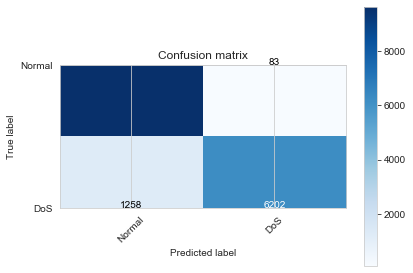

In [34]:
forest_Dos = RandomForestClassifier(random_state=1, max_depth=15, 
                                   n_estimators=500, min_samples_split=2, 
                                   min_samples_leaf=1)
                                   
modelDos_1 = forest_Dos.fit(dos_X, dos_Y)
y_pred_dos = modelDos_1.predict(test_dos_X)
print(classification_report(test_dos_Y, y_pred_dos))
plot_confusion_matrix(confusion_matrix(test_dos_Y, y_pred_dos),['Normal', 'DoS'])

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      9711
           1       0.97      0.85      0.90      7460

    accuracy                           0.92     17171
   macro avg       0.93      0.91      0.92     17171
weighted avg       0.93      0.92      0.92     17171

Confusion matrix, without normalization
[[9520  191]
 [1143 6317]]


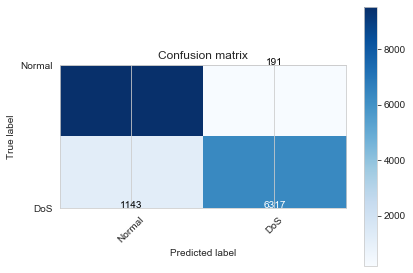

In [39]:
xgb_Dos = xgb.XGBClassifier(learning_rate=0.02, n_estimators=500, objective='binary:logistic',
                                silent=True, nthread=8, random_state=1)
modelDos_2 = xgb_Dos.fit(dos_X, dos_Y)
y_pred_dos = modelDos_2.predict(test_dos_X)
print(classification_report(test_dos_Y, y_pred_dos))
plot_confusion_matrix(confusion_matrix(test_dos_Y, y_pred_dos),['Normal', 'DoS'])

              precision    recall  f1-score   support

           0       0.87      0.98      0.92      9711
           1       0.97      0.81      0.88      7460

    accuracy                           0.90     17171
   macro avg       0.92      0.89      0.90     17171
weighted avg       0.91      0.90      0.90     17171

Confusion matrix, without normalization
[[9493  218]
 [1417 6043]]


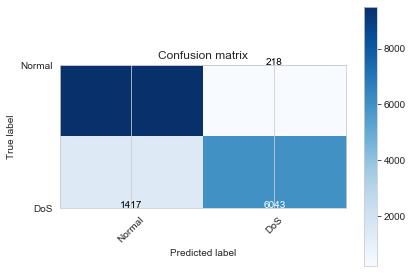

In [38]:
dtree_Dos = DecisionTreeClassifier(criterion = 'entropy', random_state=1)

modelDos_3 = dtree_Dos.fit(dos_X, dos_Y)
y_pred_dos = modelDos_3.predict(test_dos_X)
print(classification_report(test_dos_Y, y_pred_dos))
plot_confusion_matrix(confusion_matrix(test_dos_Y, y_pred_dos),['Normal', 'DoS'])

>## Probe Model training

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      9711
           2       0.86      0.60      0.71      2421

    accuracy                           0.90     12132
   macro avg       0.89      0.79      0.83     12132
weighted avg       0.90      0.90      0.89     12132

Confusion matrix, without normalization
[[9477  234]
 [ 958 1463]]


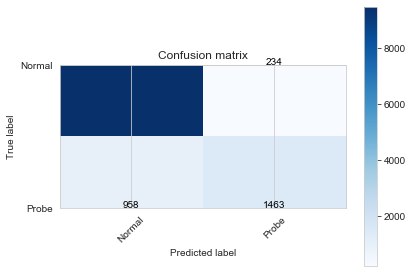

In [42]:
probe_X = X_train_dic['probe']
probe_Y = Y_train_dic['probe']
test_probe_X = X_test_dic['probe']
test_probe_Y = Y_test_dic['probe']

forest_Probe = RandomForestClassifier(random_state=1, max_depth=15, 
                                   n_estimators=500, min_samples_split=2, 
                                   min_samples_leaf=1)
                                   
modelProbe = forest_Probe.fit(probe_X, probe_Y)
y_pred_probe = modelProbe.predict(test_probe_X)
print(classification_report(test_probe_Y, y_pred_probe))
plot_confusion_matrix(confusion_matrix(test_probe_Y, y_pred_probe),['Normal', 'Probe'])

              precision    recall  f1-score   support

           0       0.91      0.98      0.94      9711
           2       0.87      0.63      0.73      2421

    accuracy                           0.91     12132
   macro avg       0.89      0.80      0.84     12132
weighted avg       0.91      0.91      0.90     12132

Confusion matrix, without normalization
[[9485  226]
 [ 889 1532]]


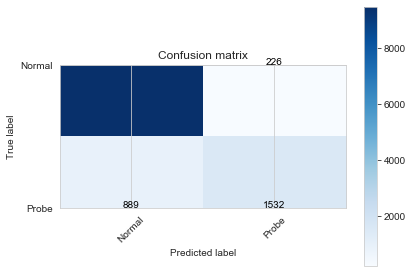

In [43]:
xgb_Probe = xgb.XGBClassifier(learning_rate=0.02, n_estimators=500, objective='binary:logistic',
                                silent=True, nthread=8, random_state=1)
                                   
modelProbe_2 = xgb_Probe.fit(probe_X, probe_Y)
y_pred_probe = modelProbe_2.predict(test_probe_X)
print(classification_report(test_probe_Y, y_pred_probe))
plot_confusion_matrix(confusion_matrix(test_probe_Y, y_pred_probe),['Normal', 'Probe'])

              precision    recall  f1-score   support

           0       0.92      0.97      0.95      9711
           2       0.86      0.66      0.75      2421

    accuracy                           0.91     12132
   macro avg       0.89      0.82      0.85     12132
weighted avg       0.91      0.91      0.91     12132

Confusion matrix, without normalization
[[9457  254]
 [ 819 1602]]


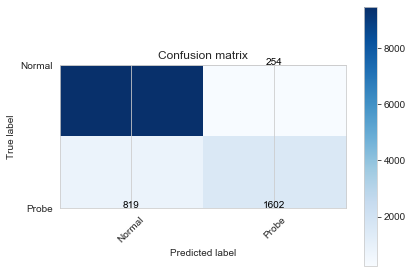

In [44]:
dtree_Probe = DecisionTreeClassifier(criterion = 'entropy', random_state=1)
                                   
modelProbe_3 = dtree_Probe.fit(probe_X, probe_Y)
y_pred_probe = modelProbe_3.predict(test_probe_X)
print(classification_report(test_probe_Y, y_pred_probe))
plot_confusion_matrix(confusion_matrix(test_probe_Y, y_pred_probe),['Normal', 'Probe'])

>## R2L Model training

              precision    recall  f1-score   support

           0       0.79      1.00      0.88      9711
           3       1.00      0.11      0.20      2885

    accuracy                           0.80     12596
   macro avg       0.89      0.55      0.54     12596
weighted avg       0.84      0.80      0.73     12596

Confusion matrix, without normalization
[[9710    1]
 [2568  317]]


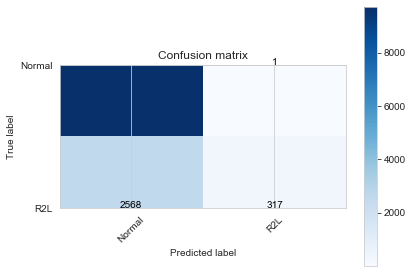

In [41]:
R2L_X = X_train_dic['R2L']
R2L_Y = Y_train_dic['R2L']
test_R2L_X = X_test_dic['R2L']
test_R2L_Y = Y_test_dic['R2L']

forest_R2L = RandomForestClassifier(random_state=1, max_depth=15, 
                                   n_estimators=500, min_samples_split=2, 
                                   min_samples_leaf=1)
                                   
modelR2L = forest_R2L.fit(R2L_X, R2L_Y)
y_pred_r2l = modelR2L.predict(test_R2L_X)
print(classification_report(test_R2L_Y, y_pred_r2l))
plot_confusion_matrix(confusion_matrix(test_R2L_Y, y_pred_r2l),['Normal', 'R2L'])



              precision    recall  f1-score   support

           0       0.79      1.00      0.88      9711
           3       1.00      0.11      0.20      2885

    accuracy                           0.80     12596
   macro avg       0.90      0.56      0.54     12596
weighted avg       0.84      0.80      0.73     12596

Confusion matrix, without normalization
[[9711    0]
 [2565  320]]


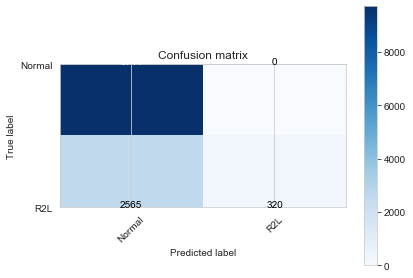

In [46]:
xgb_R2L = xgb.XGBClassifier(learning_rate=0.02, n_estimators=500, objective='binary:logistic',
                                silent=True, nthread=8, random_state=1)
                                   
modelR2L_2 = xgb_R2L.fit(R2L_X, R2L_Y)
y_pred_r2l = modelR2L_2.predict(test_R2L_X)
print(classification_report(test_R2L_Y, y_pred_r2l))
plot_confusion_matrix(confusion_matrix(test_R2L_Y, y_pred_r2l),['Normal', 'R2L'])

              precision    recall  f1-score   support

           0       0.80      1.00      0.89      9711
           3       0.99      0.15      0.26      2885

    accuracy                           0.80     12596
   macro avg       0.89      0.57      0.57     12596
weighted avg       0.84      0.80      0.74     12596

Confusion matrix, without normalization
[[9707    4]
 [2462  423]]


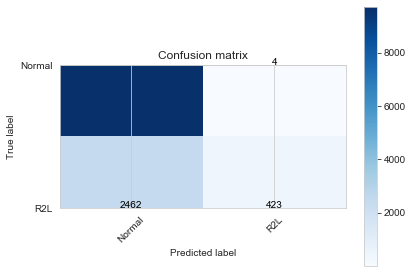

In [47]:
dtree_R2L = DecisionTreeClassifier(criterion = 'entropy', random_state=1)                              
modelR2L_3 = dtree_R2L.fit(R2L_X, R2L_Y)
y_pred_r2l = modelR2L_3.predict(test_R2L_X)
print(classification_report(test_R2L_Y, y_pred_r2l))
plot_confusion_matrix(confusion_matrix(test_R2L_Y, y_pred_r2l),['Normal', 'R2L'])

> ## U2R model Training

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      9711
           4       0.89      0.12      0.21        67

    accuracy                           0.99      9778
   macro avg       0.94      0.56      0.60      9778
weighted avg       0.99      0.99      0.99      9778

Confusion matrix, without normalization
[[9710    1]
 [  59    8]]


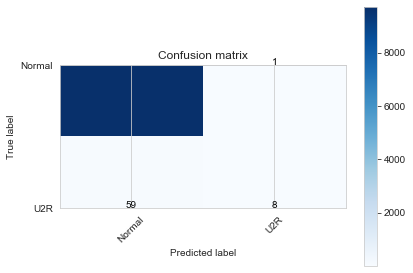

In [48]:
U2R_X = X_train_dic['U2R']
U2R_Y = Y_train_dic['U2R']
test_U2R_X = X_test_dic['U2R']
test_U2R_Y = Y_test_dic['U2R']

xgb_u2r = xgb.XGBClassifier(learning_rate=0.02, n_estimators=500, objective='binary:logistic',
                                silent=True, nthread=8, random_state=1)
modelU2R = xgb_u2r.fit(U2R_X, U2R_Y)
y_pred_u2r = modelU2R.predict(test_U2R_X)
print(classification_report(test_U2R_Y, y_pred_u2r))
plot_confusion_matrix(confusion_matrix(test_U2R_Y, y_pred_u2r),['Normal', 'U2R'])

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      9711
           4       1.00      0.16      0.28        67

    accuracy                           0.99      9778
   macro avg       1.00      0.58      0.64      9778
weighted avg       0.99      0.99      0.99      9778

Confusion matrix, without normalization
[[9711    0]
 [  56   11]]


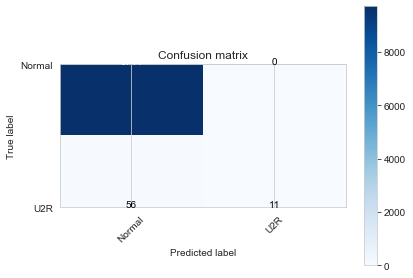

In [49]:
forest_u2r = RandomForestClassifier(random_state=1, max_depth=15, 
                                   n_estimators=500, min_samples_split=2, 
                                   min_samples_leaf=1)

modelU2R_2 = forest_u2r.fit(U2R_X, U2R_Y)
y_pred_u2r = modelU2R_2.predict(test_U2R_X)
print(classification_report(test_U2R_Y, y_pred_u2r))
plot_confusion_matrix(confusion_matrix(test_U2R_Y, y_pred_u2r),['Normal', 'U2R'])

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      9711
           4       0.89      0.36      0.51        67

    accuracy                           1.00      9778
   macro avg       0.94      0.68      0.75      9778
weighted avg       0.99      1.00      0.99      9778

Confusion matrix, without normalization
[[9708    3]
 [  43   24]]


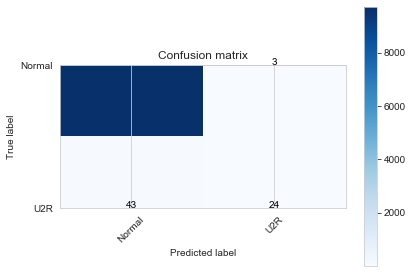

In [50]:
dtree_u2r = DecisionTreeClassifier(criterion = 'entropy', random_state=1)
modelU2R_3 = dtree_u2r.fit(U2R_X, U2R_Y)
y_pred_u2r = modelU2R_3.predict(test_U2R_X)
print(classification_report(test_U2R_Y, y_pred_u2r))
plot_confusion_matrix(confusion_matrix(test_U2R_Y, y_pred_u2r),['Normal', 'U2R'])